# Polynomial Curve Fitting and Decision Theory

Content:

1. Linear models
    - Linear function
    - Error function
    - Root meant square error
    - Optimization of Error function
    - Test the model
2. Regularization
    - Error function
    - Optimization
    - Test with regularization
3. Model Selection
    - Cross-validation
4. Bayesian curve fitting
    - Display results

## Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import  exp

import seaborn as sns; sns.set(); sns.set_palette('bright')

## Generate Data

In [2]:
def target_func(x): return np.sin(2*np.pi*x)

def generate_data(size):
    rng = np.random.RandomState(26052605)
    x_train = rng.uniform(0., 1., size)
    y_train = target_func(x_train) + rng.normal(scale=0.1, size=size)
    x_test = np.linspace(0., 1., 100)
    y_test = target_func(x_test)
    
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = generate_data(10)

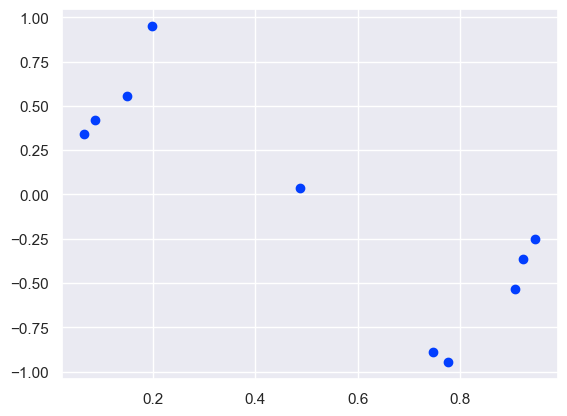

In [3]:
plt.scatter(x_train, y_train)

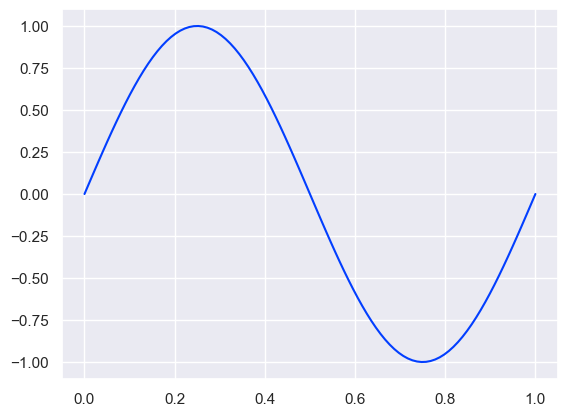

In [4]:
plt.plot(x_test, y_test, '-')

## 1) Linear models

### 1.1) Linear function

The `linear` function is designed to process a single data point x along with a list of coefficients, termed weights, corresponding to a polynomial of order M. It computes the output value y by evaluating the polynomial expression, which constructs a weighted sum of x raised to the powers from 0 to M-1. This function encapsulates the essence of polynomial curve fitting.




In [5]:
def linear(x, weights):
    x_array = np.array([x**p for p in range(len(weights))])
    return np.dot(x_array,weights)

### 1.2) Error function

The `err` function is responsible for calculating the sum-of-squared error, which quantifies the discrepancy between the predicted outputs and the actual target values. It utilizes the weights to generate predictions for a set of inputs using the polynomial model defined earlier. The function then compares these predictions against the targets by summing the squares of the differences, thereby implementing the error equation as indicated.

In [6]:
def err(weights, inputs, targets):
    return 0.5*np.sum((np.array([linear(x,weights) for x in inputs])-targets)**2)

### 1.3) Root meant square error

Function for computing the root mean squared error.

In [7]:
def erms(weights, inputs, targets):
    return np.sqrt(2 * err(weights, inputs, targets) / len(inputs))

### 1.4) Optimization of Error function

The `optimize_weights` function calculates the optimal weights for a polynomial model with order `M`. It uses the inputs and targets from the training data. The function's output is a set of optimal_weights that aligns the model's predictions closely with the actual targets.

In [8]:
def optimial_weights(inputs, targets, M):
    X = np.array([[x**p for p in range(M+1)] for x in inputs])

    return np.linalg.pinv(X.T @ X) @ X.T @ targets

### 1.5) Test the model

The test_all function evaluates the performance of polynomial models of various orders, ranging from start_M to end_M. It does so by calculating the optimal weights for each order using the training data (x_train, y_train), and then computing the error (ERMS) on both the training and testing datasets (x_test, y_test). The function returns the training and testing errors across all polynomial orders, along with the computed weights for each order. The results are then visualized in a plot showing the ERMS against the polynomial order M for both training and testing data, using a logarithmic scale for the y-axis.

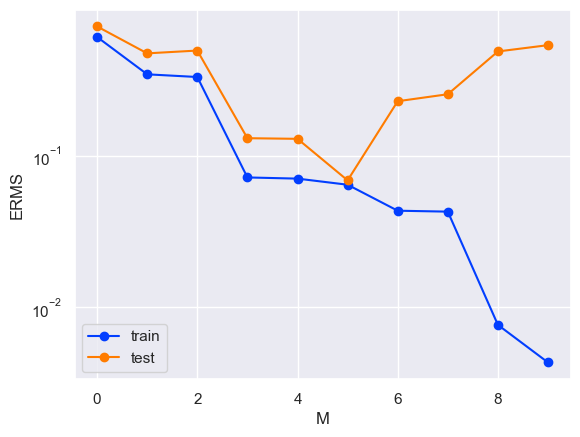

In [9]:
def test_all(start_M, end_M, x_train, y_train, x_test, y_test):
    
    results_train = []
    results_test = []
    all_weights = []
    
    for M in range(start_M, end_M + 1):
        weights = optimial_weights(x_train, y_train, M)
        all_weights.append(weights)
        error_train = erms(weights, x_train, y_train)
        error_test = erms(weights, x_test, y_test)
        results_train.append(error_train)
        results_test.append(error_test)
    return results_train, results_test, all_weights

r_tr, r_tt, all_weights = test_all(0, 9, x_train, y_train, x_test, y_test)

plt.plot(list(range(0, 10)), r_tr, '-o', label='train')
plt.plot(list(range(0, 10)), r_tt, '-o', label='test')
plt.xlabel('M')
plt.ylabel('ERMS')
plt.legend()
plt.yscale('log')

##### Weights table for different `M`

The following code lists the optimal weight vectors obtained for different model order `M` values.

In [10]:
print(pd.DataFrame(all_weights))

          0           1            2             3             4  \
0 -0.067444         NaN          NaN           NaN           NaN   
1  0.674906   -1.403250          NaN           NaN           NaN   
2  0.870601   -2.937208     1.521622           NaN           NaN   
3 -0.348533   11.654727   -33.094539     22.088529           NaN   
4 -0.274931   10.447965   -27.877273     14.161034      3.897826   
5  0.052313    2.957062    24.077616   -126.364847    164.358999   
6  1.343704  -29.263447   282.780640  -1019.109606   1661.058680   
7  1.660035  -39.467085   401.667314  -1667.834253   3460.303740   
8 -2.483362  104.722333 -1467.383452  10142.400719 -36834.599643   
9 -2.095887   87.302352 -1160.296433   7384.989581 -22979.065483   

              5             6             7             8            9  
0           NaN           NaN           NaN           NaN          NaN  
1           NaN           NaN           NaN           NaN          NaN  
2           NaN           NaN   

##### Estimated curve for `M=9` (same as the amount of data points) 

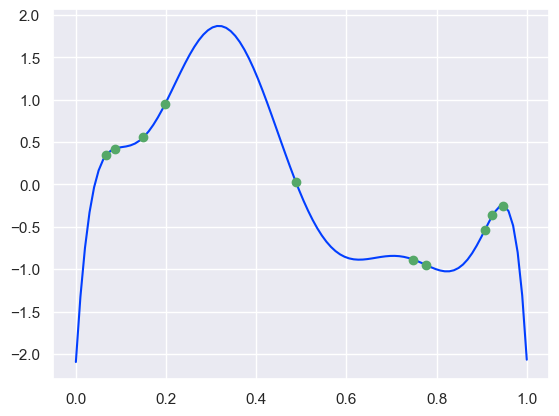

In [11]:
plt.plot(x_test, list(map(lambda x: linear(x, optimial_weights(x_train, y_train, 9)), x_test)), '-')
plt.plot(x_train, y_train, 'og')

## 2) Regularization

### 2.1) Error function

The `err_regularization` function is designed to compute the sum-of-squared error with an added regularization term to prevent overfitting. This function takes four parameters: `weights`, `inputs`, `targets`, and `l` (lambda), which is the regularization coefficient.



In [12]:
def err_regularization(weights, inputs, targets, l):
    return 1/2*np.sum((np.array([linear(x,weights) for x in inputs])-targets)**2)+l/2*np.dot(weights,weights)

Write the `erms_regularization` function which is regularization version of a root mean squared error (slide 12 in lecture 3)

In [13]:
def erms_regularization(weights, inputs, targets, l):
    return np.sqrt(2 * err_regularization(weights, inputs, targets,l) / len(inputs))

### 2.2) Optimization

The function `optimial_weights` below obtains optimial weights by implementing the optimization solution of the regularized problem. The function takes the following parameters: `inputs`, `targets`, `M` (number of weights) and `l` (regularization term) as parameters and returns optimal weights for the given set of training data.

In [14]:
def optimial_weights_regularization(inputs, targets, M, l):
    X = np.array([[x**p for p in range(M+1)] for x in inputs])
    return np.linalg.pinv(X.T @ X + np.eye(M+1)*l) @ X.T @ targets

### 2.3) Test with regularization

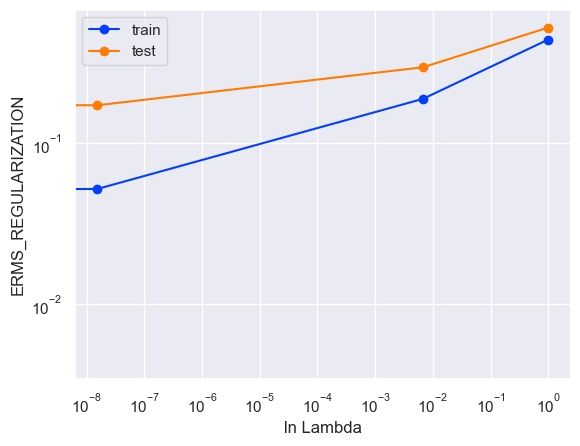

In [15]:
def test_all_regularization(ls, M, x_train, y_train, x_test, y_test):
    
    results_train = []
    results_test = []
    all_weights = []
    
    for l in ls:
        weights = optimial_weights_regularization(x_train, y_train, M, l)
        all_weights.append(weights)
        error_train = erms_regularization(weights, x_train, y_train, l)
        error_test = erms_regularization(weights, x_test, y_test, l)
        results_train.append(error_train)
        results_test.append(error_test)
    return results_train, results_test, all_weights

ls = [0, exp(-18), exp(-5), exp(0)]

r_tr_r, r_tt_r, all_weights_r = test_all_regularization(ls, 9, x_train, y_train, x_test, y_test)

plt.plot(ls, r_tr_r, '-o', label='train')
plt.plot(ls, r_tt_r, '-o', label='test')
plt.xlabel('ln Lambda')
plt.ylabel('ERMS_REGULARIZATION')
plt.legend()
plt.yscale('log')
plt.xscale('log')

##### Weights for `M=9` with regularization terms `0`, `exp(-18)`, `exp(-5)`, `exp(0)`

In [16]:
print(pd.DataFrame(np.transpose(all_weights_r)))

              0           1         2         3
0     -2.095887    0.699011  0.503543  0.328543
1     87.302352  -11.795682  0.743539 -0.389393
2  -1160.296433  121.043844 -2.425527 -0.353466
3   7384.989581 -335.150176 -1.908122 -0.232935
4 -22979.065483  217.987059 -0.795824 -0.127092
5  33681.062144  178.622535  0.106829 -0.046211
6 -13412.271397  -87.722822  0.719266  0.013218
7 -21742.764898 -148.839189  1.096707  0.055948
8  27096.941977  -12.387886  1.302133  0.085993
9  -8955.870481   78.207422  1.385740  0.106489


In [17]:
def plot_by_lambda(l):
    plt.plot(x_test, y_test, '-m')
    plt.plot(x_test, list(map(lambda x: linear(x, optimial_weights_regularization(x_train, y_train, 9, l)), x_test)), '-')
    plt.plot(x_train, y_train, 'og')

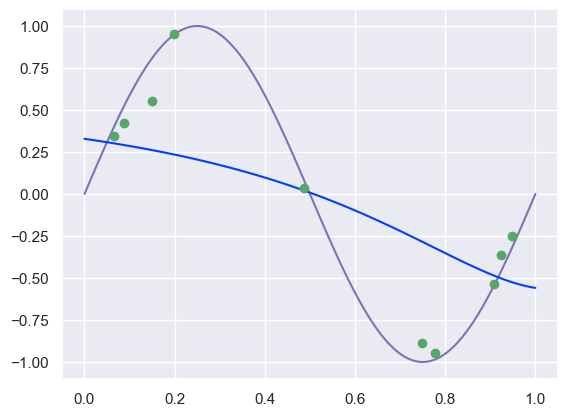

In [18]:
plot_by_lambda(exp(0))

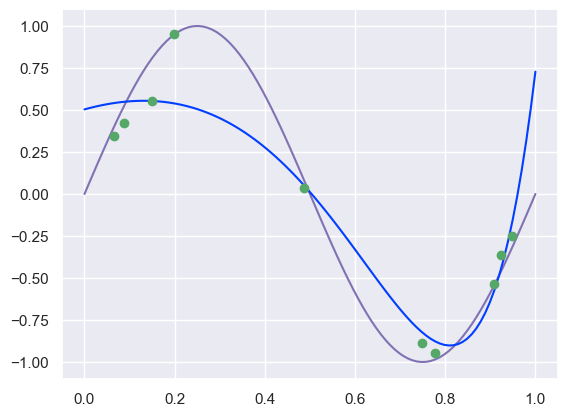

In [19]:
plot_by_lambda(exp(-5))

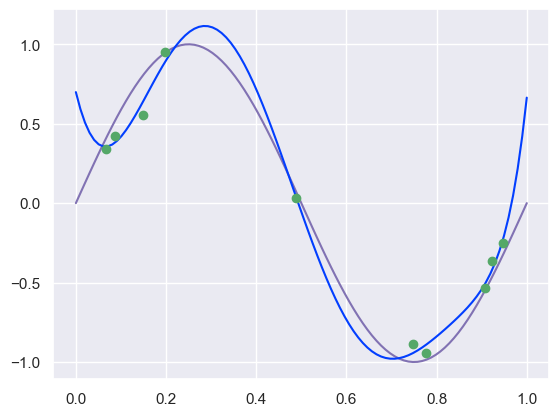

In [20]:
plot_by_lambda(exp(-18))

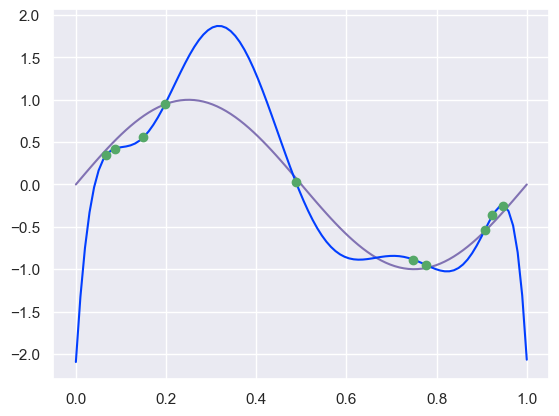

In [21]:
plot_by_lambda(0)

## 3) Model Selection

### 3.1) Cross-validation

The function `create_cross_validation_sets` takes `S` (number of sets) and training data points `x_train`, `y_train` as parameters and returns array of `S` number sets with each set in the form `[x_sub_train, y_sub_train, x_validation, y_validation]`.

The function, `best_model`, loops through all integer values between `start_M`, `end_M` (low and high limits in search of optimal value of model order `M`), performs S-fold cross validation and selects the best value `top_M` among all the considered values of M.  It also takes `ls` (a list of regularization parameters) and `sets` (cross-validation sets obtained from the output of previous function) and should return `(top_M, top_l, top_result_test)` with `M`, `l` and result for the best model.

In [22]:
def create_cross_validation_sets(S, x_train, y_train):
    x_set = np.array_split(x_train,S)
    y_set = np.array_split(y_train,S)

    res = []
    for i in range(S):
        x_sub_train = []
        y_sub_train = []
        for j in range(S):
            if not i==j:
                x_sub_train.extend(x_set[j])
                y_sub_train.extend(y_set[j])
            else :
                x_validation = x_set[j]
                y_validation = y_set[j]
        x_sub_train,y_sub_train = np.array(x_sub_train), np.array(y_sub_train) 
        x_validation,y_validation = np.array(x_validation), np.array(y_validation)
        
        res.append([x_sub_train,y_sub_train,x_validation,y_validation])
    return res

M = 5 lambda = 0 erms = 0.1064361609447928


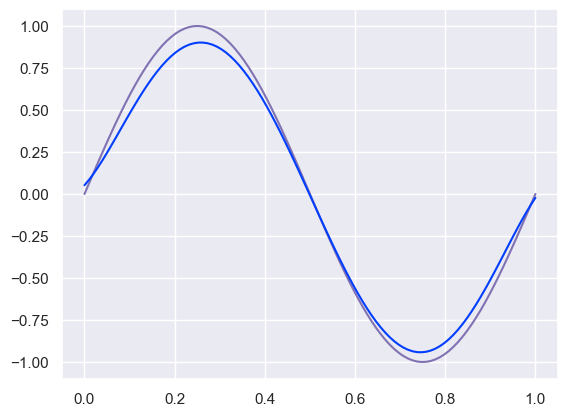

In [23]:
def best_model(start_M, end_M, ls, sets):
    top_result_test =  float("inf")
    for M in range(start_M, end_M+1):
        for l in ls:
            erms_sum = 0
            for set in sets:
                x_sub_train, y_sub_train, x_validation, y_validation = set
                weights = optimial_weights_regularization(x_sub_train, y_sub_train, M, l)
                erms_sum += erms_regularization(weights, x_validation, y_validation, l)
                
            average_erms = erms_sum / len(sets)
            if average_erms < top_result_test:
                top_M, top_l, top_result_test = M, l, average_erms
                
    return top_M, top_l, top_result_test


x_cross_train, y_cross_train, _, _ = generate_data(100) 

M, l, r = best_model(0, 9, [0, exp(-18), exp(-5), exp(0)], create_cross_validation_sets(10, x_cross_train, y_cross_train))
print('M =', M, 'lambda =', l, 'erms =', r)

plt.plot(x_test, y_test, '-m')
plt.plot(x_test, list(map(lambda x: linear(x, optimial_weights_regularization(x_train, y_train, M, l)), x_test)), '-')

## 4) Bayesian curve fitting (Optional)

The function `phi` below  takes `x` (data point) and `M` (number of weights) as arguments and returns a vector of powers of `x` from `0` to `M`

In [24]:
def phi(x, M):
    return [x**i for i in range(M)]

`S` takes `alpha`, `beta`, `x` (all data points), and `M` as arguments and returns a matrix `S` that is used to compute `mean` and `variance`

In [25]:
def S(alpha, beta, x, M):
    # Constructing the design matrix
    phi_matrix = np.array([phi(xi, M) for xi in x])

    # Calculation of S matrix
    S_matrix = np.linalg.inv(alpha * np.identity(M) + beta * np.dot(phi_matrix.T, phi_matrix))

    return S_matrix

`mean` takes `alpha`, `beta`, `x_star` (new point), `x` (all data points), `t` (target values), and `M` and computes mean for the Gaussian distribution

In [26]:
def mean(alpha, beta, x_star, x, t, M):
    # Calculation of S matrix
    S_matrix = S(alpha, beta, x, M)

    # Constructing the design matrix for the training data
    phi_matrix = np.array([phi(xi, M) for xi in x])

    # Constructing the phi vector for the new data point
    phi_x_star = np.array(phi(x_star, M))

    # Calculating the mean
    mean_value = beta * phi_x_star.dot(S_matrix).dot(phi_matrix.T).dot(t)

    return mean_value

`variance` takes `alpha`, `beta`, `x_star` (new point), `x` (all data points), `t` (target values), and `M` and computes variance for the Gaussian variance

In [27]:
def variance(alpha, beta, x_star, x, t, M):
    # Calculation of S matrix
    S_matrix = S(alpha, beta, x, M)

    # Constructing the phi vector for the new data point
    phi_x_star = np.array(phi(x_star, M))

    # Calculating the variance
    variance_value = 1 / beta + phi_x_star.dot(S_matrix).dot(phi_x_star.T)

    return variance_value

### 4.1) Display results

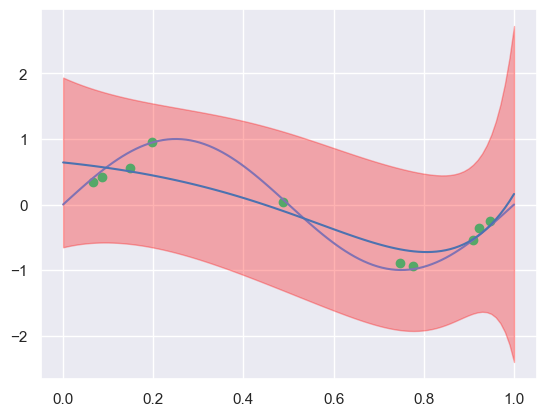

In [28]:
alpha = 0.05
beta = 1.1
M = 9

means = np.array(list(map(lambda x: mean(alpha, beta, x, x_train, y_train, M), x_test)))
variances = np.array(list(map(lambda x: variance(alpha, beta, x, x_train, y_train, M), x_test)))

plt.plot(x_train, y_train, 'og')
plt.plot(x_test, y_test, '-m')
plt.plot(x_test, means, '-b')
plt.fill_between(x_test, means + variances, means - variances, color='red', alpha=0.3)